In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping



In [18]:

# 1. 데이터 로드 (encoding='cp949' 주의)
df = pd.read_csv("dataset/seoul_pm10.csv", encoding='cp949')
print("데이터 컬럼:", df.columns)  # 파일에 있는 컬럼들을 확인
# 데이터 확인
print(df.head())

데이터 컬럼: Index(['date', 'area', 'pm10', 'pm2.5'], dtype='object')
               date area  pm10  pm2.5
0  2022-12-31 23:00  강남구  57.0   44.0
1  2022-12-31 23:00  강동구  68.0   55.0
2  2022-12-31 23:00  강북구  59.0   42.0
3  2022-12-31 23:00  강서구  62.0   40.0
4  2022-12-31 23:00  관악구  57.0   38.0


In [19]:
# 2. 날짜 변환 및 결측치 처리
# CSV 파일의 날짜 컬럼은 'date' 입니다.
df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)
df.sort_values('date', inplace=True)
df.fillna(method='ffill', inplace=True)

C:\Users\hains\AppData\Local\Temp\ipykernel_12372\2552744674.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)
C:\Users\hains\AppData\Local\Temp\ipykernel_12372\2552744674.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [20]:
# 3. 서울 지역별 원핫 인코딩
# 'area' 컬럼을 one-hot 인코딩하여, 예를 들어 '강남구'의 경우 'area_강남구' 컬럼이 생성됩니다.
df = pd.get_dummies(df, columns=['area'])
if 'area_강남구' not in df.columns:
    raise KeyError("one-hot 인코딩 후 'area_강남구' 컬럼이 없습니다. 파일의 'area' 컬럼명을 확인하세요.")

In [21]:
# 4. 강남구 데이터 필터링 및 시계열 데이터 준비
# one-hot 인코딩된 'area_강남구' 컬럼 값이 1인 행만 선택합니다.
gangnam_df = df[df['area_강남구'] == 1].copy()
# 예측 대상은 'pm10' 컬럼이며, 날짜 정보를 인덱스로 설정합니다.
gangnam_df.set_index('date', inplace=True)
pm10_values = gangnam_df['pm10'].values.reshape(-1, 1)

In [22]:

# 5. PM10 값 스케일링 및 LSTM에 적합한 시퀀스 데이터셋 생성
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_pm10 = scaler.fit_transform(pm10_values)

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 10  # 과거 10일 데이터를 이용해 다음 날을 예측
X, y = create_sequences(scaled_pm10, window_size)

In [23]:
# 6. 데이터셋 분리 (학습 데이터와 테스트 데이터)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [24]:
# 7. LSTM 모델 생성, 컴파일 및 학습
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, callbacks=[early_stop])

c:\dlProject\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0027
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.6971e-04
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.6746e-04
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.0033e-04
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.8782e-04
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5032e-04
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.2601e-04
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6595e-04
Epoch 9/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5555e-04
Epoch 10/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4202e-04
Epoch 11/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3996e-04
Epoch 12/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7400e-04
Epoch 13/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5276e-04
Epoch 14/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.

In [25]:

# 8. 예측 결과 시각화
# 테스트 데이터에 대해 예측을 수행하고, 스케일을 원래 값으로 복원합니다.
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\dlProject\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\dlProject\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\dlProject\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\dlProject\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\dlProject\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\dlProject\.venv\l

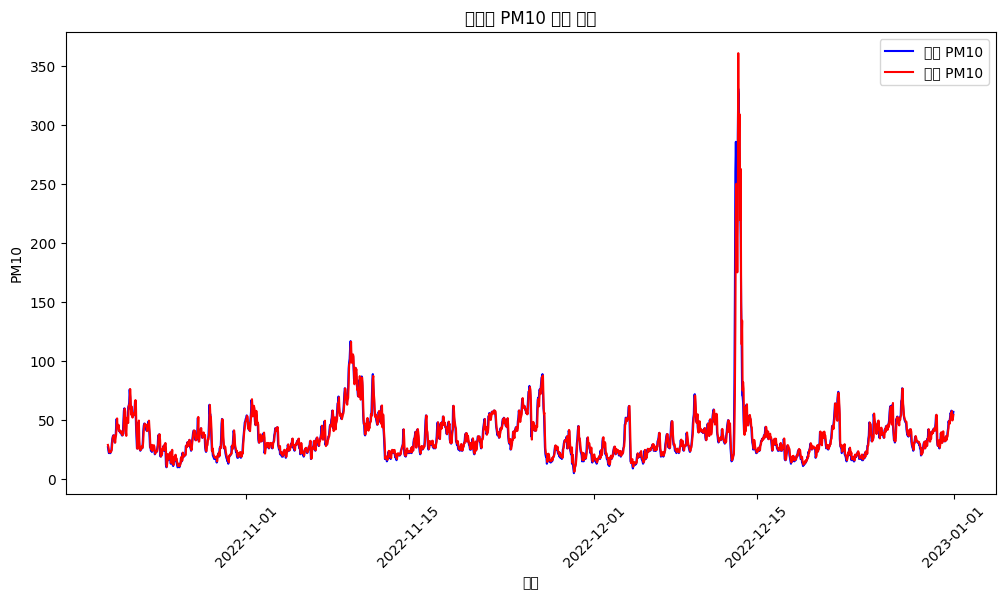

In [27]:
#시퀀스 생성으로 인해 초기 window_size 만큼의 날짜는 사용되지 않으므로,
# 테스트 데이터에 해당하는 날짜는 index에서 window_size + split부터 선택합니다.
test_dates = gangnam_df.index[window_size + split : window_size + split + len(y_test)]

plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_actual, label="실제 PM10", color='blue')
plt.plot(test_dates, y_pred, label="예측 PM10", color='red')
plt.xlabel("날짜")
plt.ylabel("PM10")
plt.title("강남구 PM10 예측 결과")
plt.legend()
plt.xticks(rotation=45)
plt.show()